# Predicting Loyalty Scores Using Machine Learning

## Description 

ABC Gocery Store recently defined a key performance metric (KPI) called `loyalty score` that ranges from 0-1: this is the percentage of the customer's grocery budget spent at ABC Grocery Store relative to other grocery stores. A consulting company sent out cold emails to all customers to obtain this information: approximately 50% of customers responded, the other 50% did not.   

The marketing team has deemed it critical to `obtain all loyalty scores` to better evaluate their customers for future marketing campaigns. 

## Problem

**classic regression problem**:
                               Given varying attributes about a customer, can we predict missing loyalty scores?    

## Data

The grocery database contains six schemas, and they are described as follows;

1. customer_details: Contains information about the customer.  Table is at customer level
2. transactions: Contains all transaction information for customers, including date of transaction, a unique transaction id, and the product area id.  Sales and number of items for each product area are aggregated.
3. product_areas: A lookup table mapping product_area_id in the transaction table, to the product area name.
4. delivery_club_campaign: A table showing which customers received mailers (mailer type and control group) as well as those who signed up for the July 1st 2019 campaign promoting a $100 per year membership which offers free grocery deliveries.
5. loyalty_scores: A table containing a loyalty score for 400 customers that a consulting company were able to match to their loyalty database that measures the percentage of grocery spend that a customer allocates to this supermarket.



## Creating our Regression Data

In [1]:
# Import required packages 
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

# Plots to appear in notebook
%matplotlib inline

## Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor

## Model evaluators
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFECV
from sklearn.inspection import permutation_importance

import warnings

In [2]:
# Import the data
loyalty_scores = pd.read_excel("data/grocery_database.xlsx", sheet_name = "loyalty_scores")
customer_details = pd.read_excel("data/grocery_database.xlsx", sheet_name = "customer_details")
transactions = pd.read_excel("data/grocery_database.xlsx", sheet_name = "transactions")

## Visualize DataFrames

In [3]:
# Visualize loyalty_scores DataFrame
loyalty_scores.head()

,customer_id,customer_loyalty_score
0,104,0.587
1,69,0.156
2,525,0.959
3,181,0.418
4,796,0.570


Column Description
1. customer_id: customer unique identifier.
2. customer_loyalty_scores: percentage of grocery spend that a customer allocates to this supermarket.

In [4]:
# Visualize loyalty_scores DataFrame
customer_details.head()

,customer_id,distance_from_store,gender,credit_score
0,74,3.38,F,0.59
1,524,4.76,F,0.52
2,607,4.45,F,0.49
3,343,0.91,M,0.54
4,322,3.02,F,0.63


Column Description
1. customer_id: customer unique identifier.
2. distance_from_store: distance a customer covers to store.
3. gender: sexual orientation.
4. credit_score: financial worthiness.

In [5]:
# Visualize transactions DataFrame
transactions.head()

,customer_id,transaction_date,transaction_id,product_area_id,num_items,sales_cost
0,1,2020-04-10,435657533999,3,7,19.16
1,1,2020-04-10,435657533999,2,5,7.71
2,1,2020-06-02,436189770685,4,4,26.97
3,1,2020-06-02,436189770685,1,2,38.52
4,1,2020-06-10,436265380298,4,4,22.13


Column Description
1. customer_id: customer unique identifier.
2. transaction_date: date a transaction occurred.
3. transaction_id: transaction unique identifier.
4. product_area_id: product name unique identifier.
5. num_items: number of items bought per transaction.
6. sales_cost: amount spent by customer per transaction.

In [6]:
# Creating a customer level dataset
data_for_regression = pd.merge(customer_details, loyalty_scores, how = "left", on = "customer_id")
data_for_regression.head()

,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score
0,74,3.38,F,0.59,0.263
1,524,4.76,F,0.52,0.298
2,607,4.45,F,0.49,0.337
3,343,0.91,M,0.54,0.873
4,322,3.02,F,0.63,0.350


By joining the customer_details table and loyalty_scores table, we effectively introduced our `customer_loyalty_scores` attribute into our new DataFrame.

## Feature Engineering

In [7]:
# Aggregate customer sales data

sales_summary = transactions.groupby(["customer_id"]).agg({"sales_cost" : "sum",
                                                           "num_items" : "sum",
                                                           "transaction_id" : "count",
                                                           "product_area_id" : "nunique"}).reset_index()

sales_summary.head(5)

,customer_id,sales_cost,num_items,transaction_id,product_area_id
0,1,3980.49,424,51,5
1,2,2056.91,213,52,5
2,3,324.22,65,12,4
3,4,3499.39,278,47,5
4,5,6609.19,987,106,5


In [8]:
# Rename columns for ease of reference

sales_summary.columns = ["customer_id", "total_sales", "total_items", "transaction_count", "product_area_count"]
sales_summary.head()

,customer_id,total_sales,total_items,transaction_count,product_area_count
0,1,3980.49,424,51,5
1,2,2056.91,213,52,5
2,3,324.22,65,12,4
3,4,3499.39,278,47,5
4,5,6609.19,987,106,5


Column Description
1. customer_id: customer unique identifier.
2. sales_cost: amount spent by customer per transaction.
3. total_items: aggregate number of purchased items.
4. transaction_count: aggregate number of transaction per customer.
5. product_area_count: aggregate number of unique product areas purchased

In [9]:
# More feature engineering. Add another column... average basket value

sales_summary["average_basket_value"] = round(sales_summary["total_sales"] / sales_summary["transaction_count"], 2)
sales_summary.head()

,customer_id,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,1,3980.49,424,51,5,78.05
1,2,2056.91,213,52,5,39.56
2,3,324.22,65,12,4,27.02
3,4,3499.39,278,47,5,74.46
4,5,6609.19,987,106,5,62.35


Column Description
1. average_basket_value: average dollar amount spent per store visit.

In [10]:
# Merge data_for_regression tabe and sales_summary table
data_for_regression = pd.merge(data_for_regression, sales_summary, how = "inner", on = "customer_id")
data_for_regression.head()

,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,74,3.38,F,0.59,0.263,2563.71,297,44,5,58.27
1,524,4.76,F,0.52,0.298,2996.02,357,49,5,61.14
2,607,4.45,F,0.49,0.337,2853.82,350,49,5,58.24
3,343,0.91,M,0.54,0.873,2388.31,272,54,5,44.23
4,322,3.02,F,0.63,0.350,2401.64,278,50,5,48.03


In [11]:
# Create DataFrame for modelling: contains customer loyalty scores.
data_for_modelling = data_for_regression.loc[data_for_regression["customer_loyalty_score"].notna()]
data_for_modelling.head()

,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,74,3.38,F,0.59,0.263,2563.71,297,44,5,58.27
1,524,4.76,F,0.52,0.298,2996.02,357,49,5,61.14
2,607,4.45,F,0.49,0.337,2853.82,350,49,5,58.24
3,343,0.91,M,0.54,0.873,2388.31,272,54,5,44.23
4,322,3.02,F,0.63,0.350,2401.64,278,50,5,48.03


In [12]:
warnings.filterwarnings("ignore")
# Create DataFrame for scoring: missing customer loyalty scores.
data_for_scoring = data_for_regression.loc[data_for_regression["customer_loyalty_score"].isna()]

# Drop empty customer_loyalty_score column
data_for_scoring.drop("customer_loyalty_score", axis = 1, inplace = True)
data_for_scoring.head()

,customer_id,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
6,1,4.78,F,0.66,3980.49,424,51,5,78.05
7,120,3.49,F,0.38,2887.20,253,45,5,64.16
8,52,14.91,F,0.68,3342.75,335,47,5,71.12
10,435,0.25,M,0.62,2326.71,267,48,5,48.47
12,679,4.74,F,0.58,3448.59,370,49,5,70.38


In [13]:
# Save files
pickle.dump(data_for_modelling, open("data/abc_regression_modelling.p", "wb"))
pickle.dump(data_for_scoring, open("data/abc_regression_scoring.p", "wb"))

## Data Preprocessing

In [14]:
###############################################################################
# Import Sample Data
###############################################################################

# Import
data_for_model = pickle.load(open("data/abc_regression_modelling.p", "rb"))

# Drop unnecessary columns
data_for_model.drop(["customer_id"], axis = 1, inplace = True)
data_for_model.head()

,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,3.38,F,0.59,0.263,2563.71,297,44,5,58.27
1,4.76,F,0.52,0.298,2996.02,357,49,5,61.14
2,4.45,F,0.49,0.337,2853.82,350,49,5,58.24
3,0.91,M,0.54,0.873,2388.31,272,54,5,44.23
4,3.02,F,0.63,0.350,2401.64,278,50,5,48.03


In [15]:
#Shuffle data
data_for_model = shuffle(data_for_model, random_state = 42)

In [16]:
###############################################################################
# Deal with Missing Values
###############################################################################

data_for_model.isna().sum()

distance_from_store       2
gender                    3
credit_score              2
customer_loyalty_score    0
total_sales               0
total_items               0
transaction_count         0
product_area_count        0
average_basket_value      0
dtype: int64

In [17]:
data_for_model.dropna(how = "any", inplace = True)
data_for_model.isna().sum()

distance_from_store       0
gender                    0
credit_score              0
customer_loyalty_score    0
total_sales               0
total_items               0
transaction_count         0
product_area_count        0
average_basket_value      0
dtype: int64

In [18]:
###############################################################################
# Deal with Outliers
###############################################################################

outlier_investigation = data_for_model.describe()

outlier_columns = ["distance_from_store", "total_sales", "total_items"]

# Boxplot approach

for column in outlier_columns:
    
    lower_quartile = data_for_model[column].quantile(0.25)
    upper_quartile = data_for_model[column].quantile(0.75)
    iqr = upper_quartile - lower_quartile
    iqr_extended = iqr * 2
    min_border = lower_quartile - iqr_extended
    max_border = upper_quartile + iqr_extended
    
    outliers = data_for_model[(data_for_model[column] < min_border) | (data_for_model[column] > max_border)].index
    print(f"{len(outliers)} outliers detected in column {column}")

2 outliers detected in column distance_from_store
23 outliers detected in column total_sales
20 outliers detected in column total_items


In [19]:
# Remove outliers
data_for_model.drop(outliers, inplace = True)

In [20]:
###############################################################################
# Split Input Varibles and Output Variables
###############################################################################

X = data_for_model.drop(["customer_loyalty_score"], axis = 1)
y = data_for_model["customer_loyalty_score"]

In [21]:
###############################################################################
# Split Train and Test Datesets
###############################################################################

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((299, 8), (75, 8), (299,), (75,))

In [22]:
###############################################################################
# Deal with Categorical Variables
###############################################################################

# Create an object to store categorical variables
categorical_vars = ["gender"]

# Instantiate OneHotEncoder
"""sparse ensure that output is an array making it easy to visualize. Drop parameter removes one dummy variable to mitigate 
dummy variable trap - input variables perfectly predicting each other"""
one_hot_encoder = OneHotEncoder(sparse = False, drop = "first")

X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded = one_hot_encoder.fit_transform(X_test[categorical_vars])


encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

# Create dataframe to hold categorical variables
X_train_encoded = pd.DataFrame(X_train_encoded, columns = encoder_feature_names)

# Concatenate dummy variables back to our original dataframe
X_train = pd.concat([X_train.reset_index(drop = True), X_train_encoded.reset_index(drop = True)], axis = 1 )

X_train.drop(categorical_vars, axis = 1, inplace= True)

# Create dataframe to hold categorical variables
X_test_encoded = pd.DataFrame(X_test_encoded, columns = encoder_feature_names)

# Concatenate dummy variables back to our original dataframe
X_test = pd.concat([X_test.reset_index(drop = True), X_test_encoded.reset_index(drop = True)], axis = 1 )

X_test.drop(categorical_vars, axis = 1, inplace= True)

## Model Training

In [23]:
# Put models in a dictionary
models = {"Linear Regression": LinearRegression(),
          "Decision Tree": DecisionTreeRegressor(random_state = 42, max_depth = 4), 
          "Random Forest": RandomForestRegressor(random_state = 42)}

# Create function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data
    X_test : testing data
    y_train : labels assosciated with training data
    y_test : labels assosciated with test data
    """
    # Random seed for reproducible results
    np.random.seed(42)
    # Make a list to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [24]:
model_scores = fit_and_score(models = models,
                             X_train = X_train,
                             X_test = X_test,
                             y_train = y_train,
                             y_test = y_test)
model_scores

{'Linear Regression': 0.7106110367882751,
 'Decision Tree': 0.8970395837191489,
 'Random Forest': 0.9325146360291109}

## Model Comparison

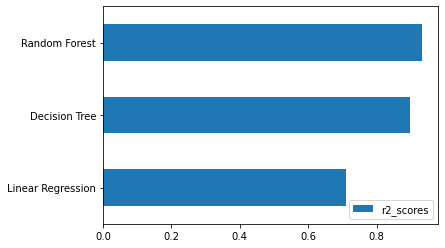

In [25]:
model_compare = pd.DataFrame(model_scores, index=['r2_scores'])
model_compare.T.plot.barh();

From our preliminary results, `RandomForestRegressor` scored highest.

## Random Forest Regressor

In [26]:
###############################################################################
# Model Training
###############################################################################

regressor = RandomForestRegressor(random_state = 42)
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [27]:
###############################################################################
# Model Assessment
###############################################################################

# Predict on the test set
y_pred = regressor.predict(X_test)

# Calculate R-Squared
r_squared = r2_score(y_test, y_pred)
r_squared

0.9325146360291109

In [28]:
# Cross Validation
cv = KFold(n_splits = 4, shuffle = True, random_state = 42)
cv_scores = cross_val_score(regressor, X_train, y_train, cv = cv, scoring = "r2")
cv_scores.mean()

0.9192168158295811

`cross_val_score()` works by taking an estimator (machine learning model) along with data and labels. It then evaluates the machine learning model on the data and labels using cross-validation and a defined scoring parameter.

In [29]:
# Calculate Adjusted R-Squared
num_data_points, num_input_vars = X_test.shape
adjusted_r_squared = 1 - (1 - r_squared) * (num_data_points - 1) / (num_data_points - num_input_vars - 1)
adjusted_r_squared

0.9243345919114274

## Feature Importance

In [30]:
# Permutation Importance
result = permutation_importance(regressor, X_test, y_test, n_repeats = 10, random_state = 42)

# To DataFrame
permutation_importance = pd.DataFrame(result["importances_mean"])
feature_names = pd.DataFrame(X.columns)
permutation_importance_summary = pd.concat([feature_names, permutation_importance], axis = 1)
permutation_importance_summary.columns = ["input_variable", "permutation_importance"]

permutation_importance_summary.sort_values(by = "permutation_importance", inplace = True)

Permutation feature importance is a model inspection technique that can be used for any fitted estimator when the data is tabular. In other words, it measures which features are contributing most to the outcome of the model.

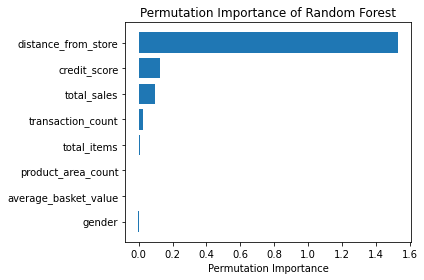

In [31]:
# Plot 
plt.barh(permutation_importance_summary["input_variable"], permutation_importance_summary["permutation_importance"])
plt.title("Permutation Importance of Random Forest")
plt.xlabel("Permutation Importance")
plt.tight_layout()
plt.show()

From the plot above, `distance_from_store` contributes the most to the model's decision.

In [32]:
# Save Objects to Pickle File
pickle.dump(regressor, open("data/random_forest_regressor_model.p", "wb"))
pickle.dump(one_hot_encoder, open("data/random_forest_regressor_ohe.p", "wb"))

## Predicting Missing Loyalty Scores

In [33]:
# Import customers for scoring
to_be_scored = pickle.load(open("data/abc_regression_scoring.p", "rb"))
to_be_scored.head()

,customer_id,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
6,1,4.78,F,0.66,3980.49,424,51,5,78.05
7,120,3.49,F,0.38,2887.20,253,45,5,64.16
8,52,14.91,F,0.68,3342.75,335,47,5,71.12
10,435,0.25,M,0.62,2326.71,267,48,5,48.47
12,679,4.74,F,0.58,3448.59,370,49,5,70.38


In [34]:
# Import model and model objects
regressor = pickle.load(open("data/random_forest_regression_model.p", "rb"))
one_hot_encoder = pickle.load(open("data/random_forest_regression_ohe.p", "rb"))


In [35]:
# Drop unused columns (customer_id)
to_be_scored.drop(["customer_id"], axis = 1, inplace = True)
to_be_scored.head()

,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
6,4.78,F,0.66,3980.49,424,51,5,78.05
7,3.49,F,0.38,2887.20,253,45,5,64.16
8,14.91,F,0.68,3342.75,335,47,5,71.12
10,0.25,M,0.62,2326.71,267,48,5,48.47
12,4.74,F,0.58,3448.59,370,49,5,70.38


In [36]:
# Find missing values
to_be_scored.isna().sum()

distance_from_store     3
gender                  2
credit_score            6
total_sales             0
total_items             0
transaction_count       0
product_area_count      0
average_basket_value    0
dtype: int64

In [37]:
# Drop missing values
to_be_scored.dropna(how = "any", inplace = True)
to_be_scored.isna().sum()

distance_from_store     0
gender                  0
credit_score            0
total_sales             0
total_items             0
transaction_count       0
product_area_count      0
average_basket_value    0
dtype: int64

In [38]:
# Apply One Hot Encoding

# Create an object to store categorical variables
categorical_vars = ["gender"]

# Instantiate OneHotEncoder
encoder_var_array = one_hot_encoder.transform(to_be_scored[categorical_vars])
encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

In [39]:
# Create dataframe to hold categorical variables
encoder_vars_df = pd.DataFrame(encoder_var_array, columns = encoder_feature_names)
encoder_vars_df.head()

,gender_M
0,0.0
1,0.0
2,0.0
3,1.0
4,0.0


In [40]:
# Concatenate dummy variables back to our original dataframe
to_be_scored = pd.concat([to_be_scored.reset_index(drop = True), encoder_vars_df.reset_index(drop = True)], axis = 1 )
to_be_scored.drop(categorical_vars, axis = 1, inplace= True)
to_be_scored.head()

,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value,gender_M
0,4.78,0.66,3980.49,424,51,5,78.05,0.0
1,3.49,0.38,2887.20,253,45,5,64.16,0.0
2,14.91,0.68,3342.75,335,47,5,71.12,0.0
3,0.25,0.62,2326.71,267,48,5,48.47,1.0
4,4.74,0.58,3448.59,370,49,5,70.38,0.0


In [41]:
# Make our predictions
loyalty_predictions = regressor.predict(to_be_scored)

In [42]:
# Loyalty predictions to a DataFrame
scored = pd.DataFrame({"customer_loyalty_score" : loyalty_predictions})
scored.head()

,customer_loyalty_score
0,0.42641
1,0.32992
2,0.34719
3,0.93166
4,0.38490
